# DOA and Beamforming
in this section we will compare between the DOA methods. the steps will be:
1. Create a phased array with 4 antennas that get at the most 3 signals.
2. Create utilizers function for the methods such as autocorrelation function and extracting the eigenvector subspaces.  
3. create the 3 methods.
4. ploting all methods


## import all nesseccery libraries

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from scipy.signal import firwin, lfilter

## phased array and producing R


the arrivale of one signal:

Class for Phased array:
- assuming isotropic antennas
- Init(ant_num, dist_between_ant, wave_lambda) - in meter units

In [3]:
class PhasedArray:
    def __init__(self, ant_num, dist_between_ant, wave_lambda):
        self.mAntNum = ant_num
        self.mDistBetweenAnt = dist_between_ant
        self.mLambda = wave_lambda

    def GetSamples(self, inVec0, theta0, inVec1 = None, theta1 = None):
        outMatrix = []
        theta0 = np.deg2rad(theta0)
        phasesVec0 = np.exp(2j * np.sin(theta0) * self.mDistBetweenAnt * np.pi * np.arange(self.mAntNum) / self.mLambda)
        outMatrix = phasesVec0[:, np.newaxis] * inVec0[np.newaxis, :]
        if inVec1 is not None and theta1 is not None:
            theta1 = np.deg2rad(theta1)
            phasesVec1 = np.exp(2j * np.sin(theta1) * self.mDistBetweenAnt * np.pi * np.arange(self.mAntNum) / self.mLambda)
            outMatrix += phasesVec1[:, np.newaxis] * inVec1[np.newaxis, :]
        return(outMatrix)


producing R

In [4]:
class RCalculator:
    def __init__(self, antenna_number, mode, alpha = None):
        self.mAntNum = antenna_number
        self.mR = np.zeros((self.mAntNum, self.mAntNum))
        self.mAlpha = alpha
        self.mMode = mode
        if mode == "alpha filter":
          if self.mAlpha is None:
              print("XxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXx")
              print("R calculator - Inset alpha value in the constructor !!")
              print("XxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXx")
              exit()
          if np.abs(self.mAlpha) > 1:
              print("XxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxX")
              print("R calculator - Alpha must be less then 1 !!")
              print("XxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxX")
              exit()
        elif mode != "avarage":
              print("XxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxX")
              print("R calculator - mode is not valid -> choose alpha filter or avarage !!")
              print("XxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxX")
              exit()

    def GetSamples(self, inMatrix):
        if self.mMode == "alpha filter":
          for i in range(inMatrix.shape[1]):
              #print(inMatrix[:,i])
              lastSampVec = inMatrix[:,i].reshape(inMatrix.shape[0], 1)
              R = lastSampVec @ lastSampVec.T
              self.mR = (1 - self.mAlpha) * self.mR + self.mAlpha * R
        else:
              self.mR = np.dot(inMatrix, inMatrix.conj().T) / inMatrix.shape[1]
        return self.mR


## DOA algorithms

### Delay-and-Sum algorithm (beam scan)

In [5]:
import numpy as np

class DS:
  def __init__(self, ant_num, dist_between_ant, wave_lambda):
    self.mAntNum = ant_num
    self.mDistBetweenAnt = dist_between_ant
    self.mLambda = wave_lambda
    #self.mInitDone = False

  def GetDS(self,R, theta_center=0,theta_span=np.pi):
    #find max and min angle -> generate the theta vec accourdingly
    leftSide= max(theta_center - (theta_span / 2), -1*np.pi/2)
    rightSide= min(theta_center + (theta_span / 2), 1*np.pi/2)
    theta_scan = np.linspace(leftSide,
                             rightSide,
                             int(theta_span * 180 / np.pi))
    #making the wieght vector
    results = []
    ant_indices = np.arange(self.mAntNum).reshape(-1, 1)  # shape (N, 1)
    sin_theta = np.sin(theta_scan).reshape(1, -1)         # shape (1, M)
    phase_shifts = -2j * np.pi * (self.mDistBetweenAnt / self.mLambda) * ant_indices @ sin_theta  # (N, M)
    W = np.exp(phase_shifts)  # shape (N, M), each column is a steering vector

    #applying the algorithem
    Power = np.diag(W.conj().T @ R @ W) # shape (M, 1)
    results = 10 * np.log10(np.abs(Power) + 1e-6)
    results -= np.max(results)
    return results, theta_scan

  def PlotTheResult(self,results, theta_scan):
    plt.plot(theta_scan * 180 / np.pi, results) # lets plot angle in degrees
    plt.xlabel("Theta [Degrees]")
    plt.ylabel("DOA Metric")
    plt.grid()
    plt.show()



### MVDR algorithm

In [6]:
class MVDR:
  def __init__(self, ant_num, dist_between_ant, wave_lambda):
    self.mAntNum = ant_num
    self.mDistBetweenAnt = dist_between_ant
    self.mLambda = wave_lambda

  def GetSamples(self, R, theta_scan=np.arange(-90, 91, 1)):
    ant_indices = np.arange(self.mAntNum).reshape(-1, 1)  # shape (N, 1)
    sin_theta = np.sin(np.radians(theta_scan)).reshape(1, -1)         # shape (1, M)
    phase_shifts = 2j * np.pi * (self.mDistBetweenAnt / self.mLambda) * ant_indices @ sin_theta  # (N, M)
    W = np.exp(phase_shifts)  # shape (N, M), each column is a steering vector
    #applying the algorithem
    R_inv = np.linalg.inv(R)
    Power= 1/(np.diag(W.conj().T @ R_inv @ W) + 1e-6) #make sure there is no zeros
    results = 10 * np.log10(np.abs(Power) + 1e-6)
    results -= np.max(results)
    return results, theta_scan

  def PlotTheResult(self,results, theta_scan):
    plt.plot(theta_scan* 180 / np.pi, results) # lets plot angle in degrees
    plt.xlabel("Theta [Degrees]")
    plt.ylabel("DOA Metric")
    plt.grid()
    plt.show()



### MUSIC algorithm


In [7]:
class MusicDoa:
    def __init__(self, ant_num, dist_between_ant, wave_lambda):
        self.mNumberOfAntennas = ant_num
        self.mDistBetweenAnt = dist_between_ant
        self.mLambda = wave_lambda
        self.mPower = None
        self.mAngles = None

    def GetSamples(self, R, scanAnglesDeg=np.arange(-90, 91, 1), signal_count=1):
        eigvals, eigvecs = np.linalg.eigh(R)
        noise_eigvecs = eigvecs[:, :-signal_count]  #vectors with the smallest eigen valuse
        angles = scanAnglesDeg
        power = []
        for theta_deg in angles:
            theta = np.deg2rad(theta_deg)
            steering_vec = np.exp(2j * np.pi * self.mDistBetweenAnt * np.sin(theta) * np.arange(self.mNumberOfAntennas) / self.mLambda).reshape(-1, 1)
            power.append(1.0 / np.linalg.norm(np.dot(noise_eigvecs.conj().T, steering_vec))**2)
        power = np.abs(power)
        power /= np.max(power)
        power_db = 10 * np.log(power + 1e-6)
        self.mPower = power_db
        self.mAngles = angles
        return angles, power_db

    def PlotPower(self):
        plt.plot(self.mAngles, self.mPower)
        plt.xlabel("Theta [Degrees]")
        plt.ylabel("DOA power calculation")
        plt.grid()
        plt.show()

### Peaks finder

In [8]:
class PeaksFinder:

    def __init__(self, peaks_num):
        self.mPeaksNum = peaks_num
        if self.mPeaksNum < 1:
            print("XxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXx")
            print("Peaks finder - Enter at least one peak to find !!!")
            print("XxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXx")
            exit()

    def GetSamples(self, power_values, scanAnglesDeg):
        peaksIdx = find_peaks(np.squeeze(power_values))[0]
        if len(peaksIdx) == 0:
            print("XxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXx")
            print("Peaks finder - No maximum points found !!!")
            print("XxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXx")
            exit()
        if self.mPeaksNum > len(peaksIdx):
            print("XxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxxXxXxXxXxXxXxXxXxXx")
            print("Peaks finder - Didnt found anoth maximum points !!!")
            print("XxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxX")
            exit()
        peaksPowers = power_values[peaksIdx]
        sortedIndices = np.argsort(peaksPowers)[::-1]
        topPeaksIdx = peaksIdx[sortedIndices[:self.mPeaksNum]]
        return scanAnglesDeg[topPeaksIdx]

### MDL - For recieved signls count estimation

In [9]:
class MdlForSigCnt:
    def __init__(self, ant_num, snapshots_for_r_calc):
        self.mAntNum = ant_num
        self.mSnapForRCalc = snapshots_for_r_calc

    def GetSamples(self, R):
        eigvals, eigvecs = np.linalg.eigh(R)
        eigvals = np.flip(np.sort(eigvals))                          #flip to decent order
        MdlVal = np.zeros(self.mAntNum - 1)
        for sig_vec_num in range(self.mAntNum - 1):
            noise_eigvals = eigvals[sig_vec_num:]
            gm = np.prod(noise_eigvals) ** (1 / len(noise_eigvals))  # geometric mean
            am = np.mean(noise_eigvals)                              # arithmetic mean
            if gm <= 0 or am <= 0:
                MdlVal[sig_vec_num] = np.inf
            else:
                regulation = 0.5 * sig_vec_num * (2 * self.mAntNum - sig_vec_num) * np.log(self.mSnapForRCalc)
                data_term = -self.mSnapForRCalc * (self.mAntNum - sig_vec_num) * np.log(gm / am)
                MdlVal[sig_vec_num] =  data_term + regulation
        EstSigVecsCnt = np.argmin(MdlVal)
        return EstSigVecsCnt

# Kalman Filter



### Kalman filter

In [10]:
class KalmanFilter:
    def __init__(self, init_pos, init_vel, init_var, measurments_var, proccess_variance):
        self.mPosition = init_pos
        self.mVelocity = init_vel
        self.mPx = init_var
        self.mPv = init_var
        self.mMeasurmentsVariance = measurments_var
        self.mProccessVariance = proccess_variance
        self.MIN_VARIANCE = 1e-4

    def GetSampels(self, input, dt):

        if isinstance(input, np.ndarray):
          outVec = []
          outVarVec = []
          for sample in input:
              pos, var = self.ApplyFilter(sample, dt)
              outVec.append(pos)
              outVarVec.append(var)
          return np.array(outVec), np.array(outVarVec)
        else:
          return self.ApplyFilter(input, dt)

    def ApplyFilter(self, measuredPos, dt):

        # --- prediction ---
        predicted_x = self.mPosition + dt * self.mVelocity
        predicted_v = self.mVelocity
        predicted_Px = self.mPx + dt**2 * self.mPv
        predicted_Pv = self.mPv

        # --- Kalman Gains ---
        k_x = predicted_Px / (predicted_Px + self.mMeasurmentsVariance)
        k_v = predicted_Pv / (predicted_Pv + self.mMeasurmentsVariance)


        # --- Update ---
        self.mPosition = predicted_x + k_x * (measuredPos - predicted_x)
        self.mVelocity = predicted_v + k_v * ((measuredPos - predicted_x) / dt)

        self.mPx = (1 - k_x) * predicted_Px
        self.mPv = (1 - k_v) * predicted_Pv

        # Ensure minimum variances
        self.mPx = max(self.mPx, self.MIN_VARIANCE)
        self.mPv = max(self.mPv + self.mProccessVariance, self.MIN_VARIANCE)

        return self.mPosition, self.mPx

###UAV class
moving object with linear nd ocsilator modes

In [11]:
class UAV:
  def __init__(self, starting_point=0,left_side=-10,right_side=10):
    self.mStartingPoint=starting_point
    self.mLeftSide=left_side
    self.mRightSide= right_side

  def OsilatorMovment(self,omega=1,range=20,durationTime=60,numberOfPointsToMeasure=121): #Samplee rate + range to amplitude and cemnter
    time=np.linspace(0,durationTime,numberOfPointsToMeasure)
    UAV_position_results=[]
    UAV_Postition=0
    for t in time:
      UAV_Postition = self.mStartingPoint +20*np.sin(omega*t)
      UAV_position_results.append(float(UAV_Postition))
    print(UAV_position_results)
    return UAV_position_results
  def StraightMovment(self,velocity=1,durationTime=20,numberOfPointsToMeasure=21):
      time=np.linspace(0,durationTime,numberOfPointsToMeasure)
      UAV_position_results=[]
      UAV_Postition=0
      for i in range(1, len(time)):
          delta_t = time[i] - time[i - 1]
          UAV_Postition += velocity*delta_t
          UAV_position_results.append(float(UAV_Postition))
      return UAV_position_results

# Test Banchs

##### Test banch - several peaks finiding

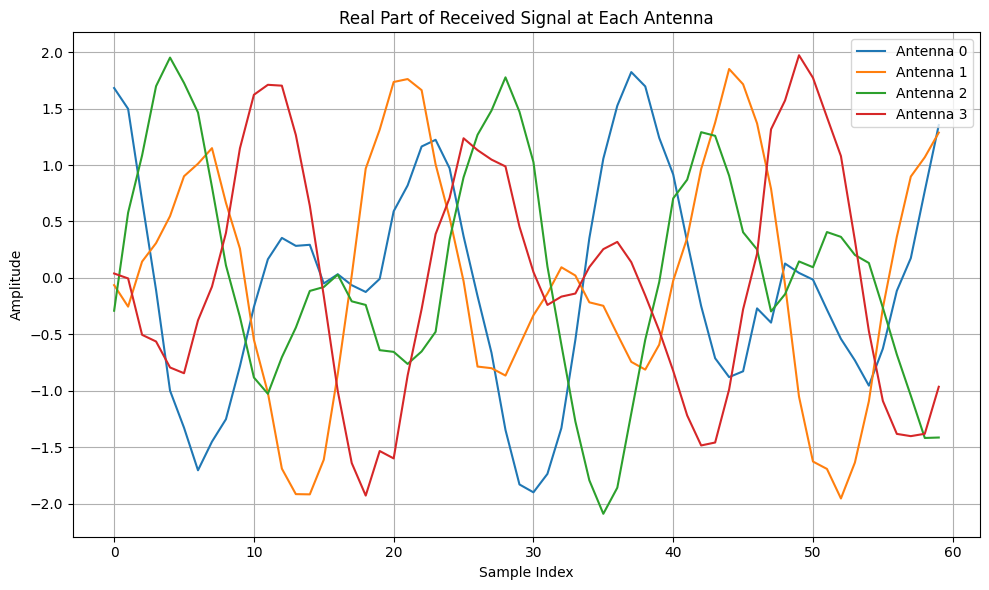

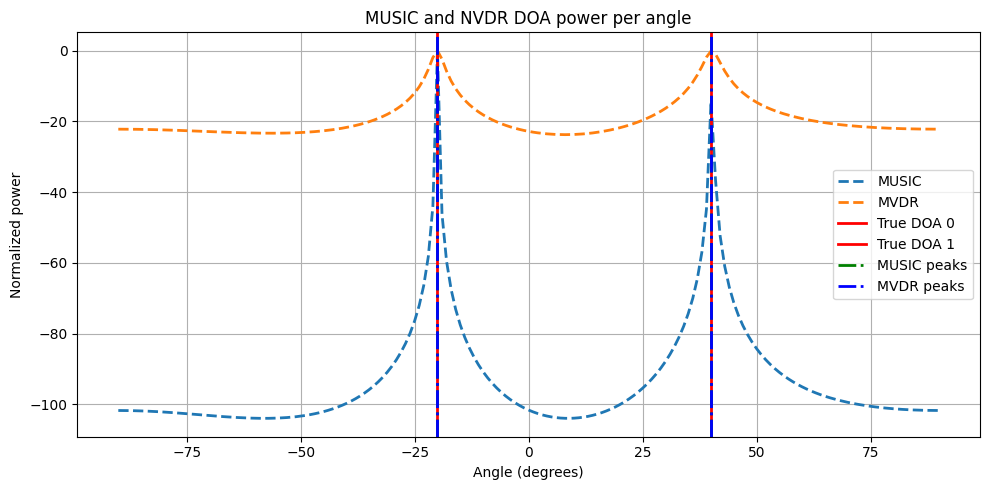

In [12]:
# Test Parameters
num_antennas = 4
num_of_samples = 60
wavelength = 1.0
d = wavelength / 2
t = np.linspace(1, num_of_samples, num_of_samples)
signal0 = np.exp(1j * 2 * np.pi * 0.05 * t)
angle0 = -20
signal1 = np.exp(1j * 2 * np.pi * 0.08 * t)
angle1 = 40

# Phased array to simulate received signals
pa = PhasedArray(num_antennas, d, wavelength)
received_matrix = pa.GetSamples(signal0, angle0, signal1, angle1)

# Add some noise
noise_power = 0.1
received_matrix += noise_power * (np.random.randn(*received_matrix.shape) + 1j * np.random.randn(*received_matrix.shape))# shpae

#FIX - add mdl

# Calc R
R_Calculator = RCalculator(num_antennas, "avarage")
R = R_Calculator.GetSamples(received_matrix)

# Apply MDL
Mdl = MdlForSigCnt(num_antennas, num_of_samples)
sig_cnt = Mdl.GetSamples(R)

# Apply MUSIC
music = MusicDoa(num_antennas, d, wavelength)
angles_music, power_music = music.GetSamples(R, signal_count=sig_cnt)

# Apply MVDR
mvdr = MVDR(num_antennas, d, wavelength)
power_mvdr, angles_mvdr = mvdr.GetSamples(R)

# Extract maximum
peaksFinder = PeaksFinder(sig_cnt)
musicPeacks = peaksFinder.GetSamples(power_music, angles_music)
mvdrPeacks = peaksFinder.GetSamples(power_mvdr, angles_mvdr)

# Plot - phased array output
plt.figure(figsize=(10, 6))
for i in range(received_matrix.shape[0]):
    plt.plot(np.real(received_matrix[i]), label=f"Antenna {i}")
plt.title("Real Part of Received Signal at Each Antenna")
plt.xlabel("Sample Index")
plt.ylabel("Amplitude")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot - DOA algorithms performance
plt.figure(figsize=(10, 5))
plt.plot(angles_music, power_music, label="MUSIC", linewidth=2, linestyle='--')
plt.plot(angles_mvdr, power_mvdr, label="MVDR", linewidth=2, linestyle='--')
plt.axvline(x=angle0, color='r', linestyle='-', linewidth=2, label="True DOA 0")
plt.axvline(x=angle1, color='r', linestyle='-', linewidth=2, label="True DOA 1")
for i in range(2):
    if i:
        plt.axvline(x=musicPeacks[i], color='g', linestyle='-.', linewidth=2)
        plt.axvline(x=mvdrPeacks[i], color='b', linestyle='-.', linewidth=2)
    else:
        plt.axvline(x=musicPeacks[i], color='g', linestyle='-.', linewidth=2, label="MUSIC peaks")
        plt.axvline(x=mvdrPeacks[i], color='b', linestyle='-.', linewidth=2, label="MVDR peaks")
plt.title("MUSIC and NVDR DOA power per angle")
plt.xlabel("Angle (degrees)")
plt.ylabel("Normalized power")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

## Kalman for UAV




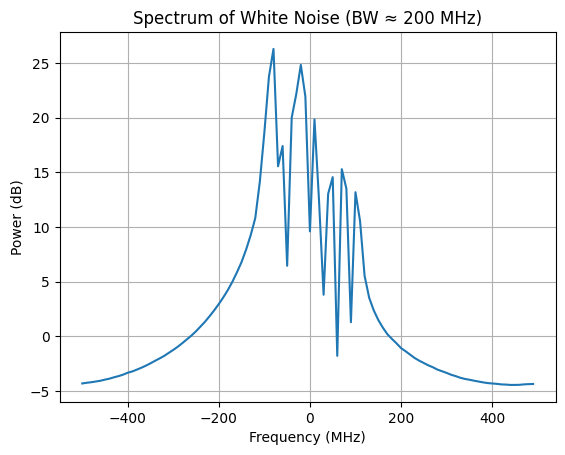

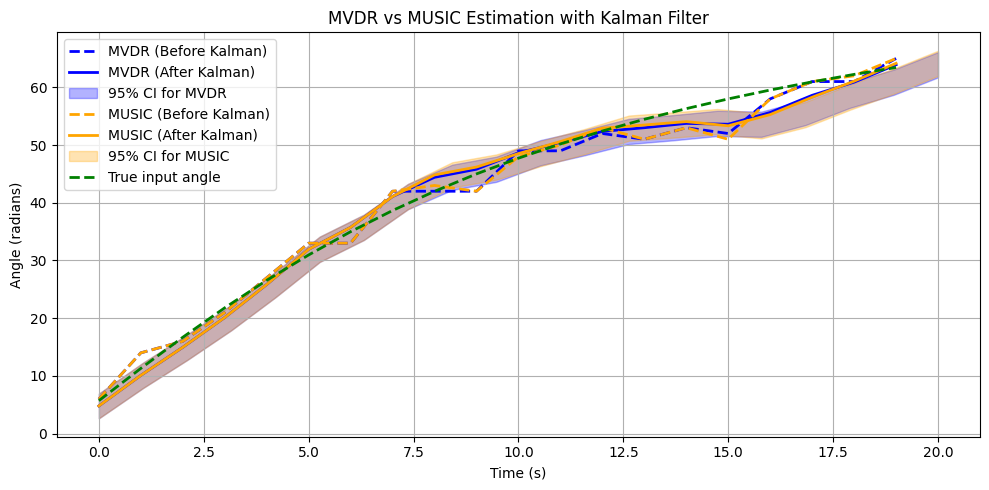

In [16]:
#Simulation parameters
num_antennas = 4
snr = 10
rf_freq = 28e9
sample_freq = 1e9
bw = 200e6
num_of_samples = 20

#System decleration
wavelength = 3e8 / rf_freq
d = wavelength / 2

uav=UAV()
pa = PhasedArray(num_antennas, d, wavelength)
Mdl = MdlForSigCnt(num_antennas, num_of_samples)
mvdr = MVDR(num_antennas, d, wavelength)
music = MusicDoa(num_antennas, d, wavelength)
Kalman_MVDR = KalmanFilter(init_pos=2, init_vel=2, init_var=1, measurments_var=3, proccess_variance=0.2)
Kalman_MUSIC = KalmanFilter(init_pos=2, init_vel=2, init_var=1, measurments_var=3, proccess_variance=0.2)

MVDR_before_kalman = []
MVDR_after_kalman = []
MUSIC_before_kalman = []
MUSIC_after_kalman = []

#moving object
position_linear= uav.StraightMovment()
time_linear= np.linspace(0, 20, num_of_samples)
theta_linear_movment = np.rad2deg(np.arctan(np.array(position_linear) / 10)) #imagine the trget is 10 m away horizontally

#Feeding the system with smples
for theta in theta_linear_movment:

    #generate recieved signal
    num_of_samples = 100
    noise = np.random.normal(0, 1, num_of_samples) + 1j * np.random.normal(0, 1, num_of_samples)
    cutoff = bw / sample_freq  # Normalize cutoff frequency (to Nyquist = fs/2)
    taps = firwin(numtaps=101, cutoff=cutoff, window="hamming")
    signal0 = lfilter(taps, 1.0, noise)
    received_matrix = pa.GetSamples(signal0, theta)
    noise_power = np.sqrt(2) / np.sqrt(snr)
    received_matrix += noise_power * (np.random.randn(*received_matrix.shape) + 1j * np.random.randn(*received_matrix.shape))

    #algorithem for finding the theta
    R_Calculator = RCalculator(num_antennas, "avarage")
    R = R_Calculator.GetSamples(received_matrix)

    # Apply MDL
    sig_cnt = 1
    if snr > 10:
      sig_cnt = Mdl.GetSamples(R)

    #DOA
    power_mvdr, angles_mvdr = mvdr.GetSamples(R)
    angles_music, power_music = music.GetSamples(R, signal_count=sig_cnt)

    # Extract maximum
    peaksFinder = PeaksFinder(sig_cnt)
    mvdrPeacks = peaksFinder.GetSamples(power_mvdr, angles_mvdr)
    musicPeacks = peaksFinder.GetSamples(power_music, angles_music)
    MVDR_before_kalman.append(mvdrPeacks)
    MUSIC_before_kalman.append(musicPeacks)

#Applying klman filter
MVDR_before_kalman = np.squeeze(np.array(MVDR_before_kalman))
outMVDR, outVarMVDR = Kalman_MVDR.GetSampels(MVDR_before_kalman, 1)
MUSIC_before_kalman = np.squeeze(np.array(MUSIC_before_kalman))
outMUSIC, outVarMUSIC = Kalman_MUSIC.GetSampels(MUSIC_before_kalman, 1)

MVDR_after_kalman = np.squeeze(np.array(outMVDR))
MUSIC_after_kalman = np.squeeze(np.array(outMUSIC))

# --- Convert to NumPy arrays for math ---
MVDR_after_kalman = np.squeeze(np.array(MVDR_after_kalman))
MUSIC_after_kalman = np.squeeze(np.array(MUSIC_after_kalman))

# --- 95% Confidence intervals (±1.96 * std) ---
ciMVDR = 1.96 * np.sqrt(outVarMVDR)
ciMUSIC = 1.96 * np.sqrt(outVarMUSIC)

# --- Plotting input spectrum ---
freqs = np.fft.fftfreq(len(signal0), d=1/sample_freq)
spectrum = np.fft.fft(signal0)
plt.plot(np.fft.fftshift(freqs)/1e6, 10*np.log10(np.fft.fftshift(np.abs(spectrum)**2)))
plt.title("Spectrum of White Noise (BW ≈ 200 MHz)")
plt.xlabel("Frequency (MHz)")
plt.ylabel("Power (dB)")
plt.grid()
plt.show()

# --- Plotting Kalmans estimations ---      # FIX - seperate to 2 graphs
plt.figure(figsize=(10, 5))

plt.plot(MVDR_before_kalman, linestyle='--', color='blue', label='MVDR (Before Kalman)', linewidth=2)
plt.plot(MVDR_after_kalman, linestyle='-', color='blue', label='MVDR (After Kalman)', linewidth=2)
plt.fill_between(time_linear, MVDR_after_kalman - ciMVDR, MVDR_after_kalman + ciMVDR, color='blue', alpha=0.3, label='95% CI for MVDR')

plt.plot(MUSIC_before_kalman, linestyle='--', color='orange', label='MUSIC (Before Kalman)', linewidth=2)
plt.plot(MUSIC_after_kalman, linestyle='-', color='orange', label='MUSIC (After Kalman)', linewidth=2)
plt.fill_between(time_linear, MUSIC_after_kalman - ciMUSIC, MUSIC_after_kalman + ciMUSIC, color='orange', alpha=0.3, label='95% CI for MUSIC')

plt.plot(theta_linear_movment, linestyle='--', color='green', label='True input angle', linewidth=2)

plt.xlabel('Time (s)')
plt.ylabel('Angle (radians)')
plt.title('MVDR vs MUSIC Estimation with Kalman Filter')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## UAV (moving target) test banch

In [ ]:
uav=UAV()
position_osilator = uav.OsilatorMovment(numberOfPointsToMeasure=40)
time_osilator = np.linspace(0, 60, 40)

position_linear= uav.StraightMovment()
time_linear= np.linspace(0, 20, 20)

plt.figure(figsize=(10, 3))  # Wider aspect for 1D plotting

# Plot 2D time vs position
plt.subplot(2, 2, 1)
plt.plot(time_osilator, position_osilator, marker='x', linestyle='')
plt.xlabel("Time [s]")
plt.ylabel("UAV Position")
plt.title("UAV Oscillator Movement")
plt.grid()

# Plot 1D position
plt.subplot(2, 2, 2)
plt.plot(position_osilator, [0]*len(position_osilator), marker='x', linestyle='', markersize=8, color='red')
plt.xlim(-20, 20)
plt.ylim(-1, 1)
plt.yticks([])
plt.xlabel("UAV Position")
plt.title("UAV 1D Position on Scale")
plt.grid(True, axis='x')

# Plot 2D time vs position
plt.subplot(2, 2, 3)
plt.plot(time_linear, position_linear, marker='x', linestyle='')
plt.xlabel("Time [s]")
plt.ylabel("UAV Position")
plt.title("UAV Oscillator Movement")
plt.grid()

# Plot 1D position
plt.subplot(2, 2, 4)
plt.plot(position_linear, [0]*len(position_linear), marker='x', linestyle='', markersize=8, color='red')
plt.xlim(-20, 20)
plt.ylim(-1, 1)
plt.yticks([])
plt.xlabel("UAV Position")
plt.title("UAV 1D Position on Scale")
plt.grid(True, axis='x')

plt.tight_layout()
plt.show()
